<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/sandbox/object_detection_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [128]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         88           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         76           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        909           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        145           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1674           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14599            True  
house-pr

In [129]:
!kaggle datasets download "andrewmvd/road-sign-detection" --unzip

100% 218M/218M [00:01<00:00, 171MB/s]
100% 218M/218M [00:01<00:00, 165MB/s]


In [130]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [131]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [132]:
images_path = Path('./images')
anno_path = Path('./annotations')

In [133]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [134]:
df_train = generate_train_df(anno_path)

In [135]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [136]:
print(df_train.shape)
print(len(df_train))
df_train.head()

(877, 8)
877


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road574.png,300,400,0,86,202,206,327
1,images/road481.png,300,400,0,90,230,144,284
2,images/road779.png,300,400,0,68,142,195,269
3,images/road649.png,300,400,0,127,155,154,183
4,images/road226.png,300,400,0,134,175,156,197


In [137]:
df_train = df_train.reset_index()

In [138]:
df_train.head()

,index,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,images/road574.png,300,400,0,86,202,206,327
1,1,images/road481.png,300,400,0,90,230,144,284
2,2,images/road779.png,300,400,0,68,142,195,269
3,3,images/road649.png,300,400,0,127,155,154,183
4,4,images/road226.png,300,400,0,134,175,156,197


In [139]:
X = df_train
Y = df_train

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reset_index()
X_val = X_val.reset_index()

In [141]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


hparam = {'batch_size': 64, 'image_size': (224, 224),
          'shuffle': True, 'num_workers': 2,
          'mean_color': [0.485, 0.456, 0.406, 0], 'std_color': [0.229, 0.224, 0.225, 1]}

transform = {
    "train":transforms.Compose([
        transforms.Resize((400, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(hparam['mean_color'], hparam['std_color']),
        ]),
    "val":transforms.Compose([
        transforms.Resize((400, 300)),
        transforms.Normalize(hparam['mean_color'], hparam['std_color']),
        ])
}


class RoadDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.preprocess = transforms.Compose([
            transforms.ToTensor(),
        ])
        

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        path = self.dataframe["filename"][idx]
        y_class = self.dataframe["class"][idx]
        bbox = [self.dataframe["xmin"][idx], self.dataframe["ymin"][idx], self.dataframe["xmax"][idx], self.dataframe["ymax"][idx]]
        bbox = torch.tensor(bbox)
        out_img = Image.open(path)
        out_img = self.preprocess(out_img)
        mask = torch.zeros((out_img.shape[1], out_img.shape[2]))
        mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
        out_img = torch.cat((out_img[0:3], mask.unsqueeze(0)), 0)
        if self.transform:
            out_img = self.transform(out_img)
        bbox = torch.cat((out_img[-1].nonzero()[:, 1].min().unsqueeze(0), out_img[-1].nonzero()[:, 0].min().unsqueeze(0), out_img[-1].nonzero()[:, 1].max().unsqueeze(0), out_img[-1].nonzero()[:, 0].max().unsqueeze(0)), 0)
        return out_img[0:3], y_class, bbox

train_ds = RoadDataset(X_train , transform=transform["train"])
val_ds = RoadDataset(X_val , transform=transform["val"])

In [142]:
print(len(df_train))
print(len(train_ds))
print(len(val_ds))

877
701
176


In [143]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=batch_size)

In [144]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [145]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [146]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [147]:
def val_metrics(model, valid_dl, C=1000):
    with torch.no_grad():
        model.eval()
        total = 0
        sum_loss = 0
        correct = 0 
        for x, y_class, y_bb in valid_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            _, pred = torch.max(out_class, 1)
            correct += pred.eq(y_class).sum().item()
            sum_loss += loss.item()
            total += batch
    return sum_loss/total, correct/total

In [148]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [149]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.525 val_loss 75634.548 val_acc 0.773
train_loss 1.795 val_loss 367.510 val_acc 0.085
train_loss 1.407 val_loss 4.925 val_acc 0.773
train_loss 1.314 val_loss 1.321 val_acc 0.716
train_loss 1.205 val_loss 1.602 val_acc 0.790
train_loss 1.167 val_loss 1.033 val_acc 0.795
train_loss 0.953 val_loss 0.877 val_acc 0.795
train_loss 0.880 val_loss 0.743 val_acc 0.807
train_loss 0.869 val_loss 1.083 val_acc 0.739
train_loss 0.838 val_loss 0.762 val_acc 0.801
train_loss 0.824 val_loss 0.950 val_acc 0.778
train_loss 0.840 val_loss 0.821 val_acc 0.795
train_loss 0.871 val_loss 0.849 val_acc 0.716
train_loss 0.916 val_loss 0.927 val_acc 0.744
train_loss 0.868 val_loss 1.025 val_acc 0.710


0.8675241021388947

In [150]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.842 val_loss 0.739 val_acc 0.795
train_loss 0.844 val_loss 0.688 val_acc 0.818
train_loss 0.803 val_loss 0.692 val_acc 0.812
train_loss 0.790 val_loss 0.703 val_acc 0.807
train_loss 0.791 val_loss 0.671 val_acc 0.835
train_loss 0.788 val_loss 0.677 val_acc 0.824
train_loss 0.758 val_loss 0.661 val_acc 0.830
train_loss 0.731 val_loss 0.645 val_acc 0.835
train_loss 0.727 val_loss 0.668 val_acc 0.818
train_loss 0.728 val_loss 0.650 val_acc 0.824


0.7276224198933164

trafficlight


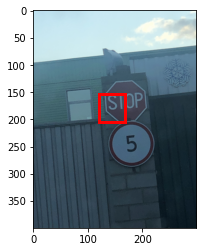

In [151]:
class_dict = {0:'speedlimit', 1:'stop', 2:'crosswalk', 3:'trafficlight'}
sample_val_data = next(iter(valid_dl))
linewidth = 3
target_num = 6

with torch.no_grad():
    result = model(sample_val_data[0].cuda().float())


def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

img = ((sample_val_data[0][target_num] * torch.tensor(hparam["std_color"][:3]).unsqueeze(-1).unsqueeze(-1)) + torch.tensor(hparam['mean_color'][:3]).unsqueeze(-1).unsqueeze(-1)).permute(1,2,0).numpy()
# bbox = sample_val_data[2][target_num].int()
bbox = result[1][target_num].int()
print(class_dict[torch.max(result[1], 1)[1][target_num].item()])

show_corner_bb(img, bbox.detach().cpu())

# crop = img[bbox[1]:bbox[3], bbox[0]:bbox[2], :].clone()
# img[bbox[1]+linewidth:bbox[3]-linewidth, bbox[0]+linewidth:bbox[2]-linewidth, :] = torch.tensor((255, 0, 0))
# img[bbox[1]:bbox[3], bbox[0]:bbox[2], :] = crop

# fig = plt.figure(figsize=(16, 8))
# plt.subplot(1,2,1)
# plt.imshow(crop)
# plt.subplot(1,2,2)
# plt.imshow(img)